# Applying Molecular Dynamics to crystal structures

Based on the paper: https://iopscience.iop.org/article/10.1088/0953-8984/25/39/395502/pdf

The spline functions being used are: EAM4

The class requires as input a set of positions of the atoms in the crystal, the properties such as potential and force are then calculated automatically and can be found by using '.potential' or '.force' etc.

Note: 

The objects of the class i.e 'potential', 'force' are in lower case

Whilst the functions of the class are capitalized i.e 'Potential', 'Force'

In [823]:
''' Import necessary packages '''
import os
import numpy as np
import scipy as sp
import itertools
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
%matplotlib inline

In [887]:
''' The main class requires as input a set of co-ordinates of the atom locations in the crystal'''
class Molecular_Dynamics:
    
    def __init__(self,xyz, box, vel = None, cutoff = 6, mr = 183.84):
        
        
        ''' To Initialize the Parameters such as Potential, Force and Hessian use Update Properties '''
        
        self.spline_phi = np.array([
            
            [
                 0.954071477542914e2,
                -0.181161004448916e3,
                 0.930215233132627e2,
                -0.108428907515182e2,
                 0.112027468539573e2,
                -0.312459176640227e1,
                 0.123028140617302e1,
                 0.154767467307454e1,
                -0.128861387780439e1,
                -0.843327493551467e0,
                 0.214009882965042e1,
                -0.102898314532388e1,
                 0.138163259601912e1,
                -0.360872433001551e1,
                 0.217655968740690e1
                
            ],
            
            [
                2.564897500000000,
                2.629795000000000,
                2.694692500000000,
                2.866317500000000,
                2.973045000000000,
                3.079772500000000,
                3.516472500000000,
                3.846445000000000,
                4.176417500000000,
                4.700845000000000,
                4.895300000000000,
                5.089755000000000,
                5.342952500000000,
                5.401695000000000,
                5.460437500000000
            ]
        ])
        
        self.spline_rho = np.array([
            
            [ 
                -0.420429107805055e1,
                 0.518217702261442e0,
                 0.562720834534370e-1,
                 0.344164178842340e-1
                
            ],

            [
                2.500000000000000,
                3.100000000000000,
                3.500000000000000,
                4.900000000000000
            ]
        ])
        
        self.spline_F = np.array([-5.553986589859130,
                                  -0.045691157657292])
        
        #Initialize all the attributes
    
        self.potential = None
        self.force = None
        self.hessian = None
        
        self.vel = vel
        self.box = box
        self.xyz = xyz
        self.cutoff = cutoff

        # Convert 1 amu to eV(ps/A)^2
        amu_conv = 931.49432e6*2.99792458e6**-2

        #Find the mass of a single atom in eV(ps/A)^2
        self.m = mr*amu_conv

        #Apply Periodic Boundary Conditions to the position
        self.Apply_PBC_xyz()
        
    def Apply_PBC_xyz(self):
        
        #Round the values for more numerical stability - prevent truncation errors
        self.xyz = np.round(self.xyz, decimals = 10)

        #Standard Equation for PBC - wiki
        for idx, pos in enumerate(self.xyz):
            self.xyz[idx] = pos - np.floor(pos / self.box[0]) * self.box[0]
        
        #Evaluate the KDTree and find the neighbours to each atom
        kdtree = KDTree(self.xyz, boxsize = self.box)
        self.neighbors = kdtree.query_ball_point(self.xyz , self.cutoff, np.inf)
    
    def Update_Properties(self, calc_potential = True, calc_force = True, calc_hessian = True):
        
        ''' Simply Updates the Properties: Potential, Force and Hessian, if a property does not need to be update simply input False'''
        if calc_potential:
            self.potential = self.Potential()
        if calc_force:
            self.force = self.Force()
        if calc_hessian:
            self.hessian = self.Hessian()
        
    def init_velocity(self, T = 300):

        '''Initialize the Velocities of each Atom based on the Maxwel Boltzmann Distribution'''
        k = 8.617333262e-5
        m_inv = 1/(self.m)

        self.vel = np.hstack([
                
                np.random.normal(loc = 0, scale = np.sqrt(k*T*m_inv), size = (len(self.xyz),1)),
                np.random.normal(loc = 0, scale = np.sqrt(k*T*m_inv), size = (len(self.xyz),1)),
                np.random.normal(loc = 0, scale = np.sqrt(k*T*m_inv), size = (len(self.xyz),1))

        ])
 
    def Phi(self, dij):
        ''' Evaluate the Interatomic Pairwise Potential - using Spline Functions'''

        mask_phi = (self.spline_phi[1, :] > dij).astype(int)
        phi = np.sum(mask_phi * self.spline_phi[0, :] * 
                         (self.spline_phi[1, :] - dij)**3, axis=1)
        
        # Divide by 2 to account for double counting of the potentials
        return phi/2
        
    def Density(self, dij):
        ''' Evaluate the Electron Density Surrounding an Atom - using Spline Functions'''

        dij = np.clip(dij, a_min = 2.002970124727, a_max = None)
        mask_rho = (self.spline_rho[1, :] > dij).astype(int)
        density = np.sum(mask_rho * self.spline_rho[0, :] * 
                 (self.spline_rho[1, :] - dij)**3, axis=1)
        return density
    
    def F(self, density):
        ''' Evaluate the resulting potential from the Electron Density around an atom'''

        F = self.spline_F[0] * np.sqrt(density) + self.spline_F[1] * density **2
        return F
    
    def Distance_Enum(self, i, j_all):
        ''' Applying the Periodic Boundary Conditions using Enumeration and seeing if wrapping the atom around optimizes the distance'''

        a = [0, 1, -1]
        combinations = list(itertools.product(a, repeat=3))

        rij = np.zeros([len(j_all),3])
        dij = np.zeros([len(j_all),1])
        
        for l,j in enumerate(j_all):

            enum = np.array(
                 [ np.linalg.norm(self.xyz[i] - self.xyz[j] - k*self.box)  for k in combinations] 
                           )
          
            idx  = np.argmin(enum)
            dij[l] = enum[idx]
            rij[l] = self.xyz[i] - self.xyz[j] - combinations[idx]

        return rij, dij
    
    def Distance(self, xyz_i, xyz_j, delta = np.zeros(3)):
        ''' Applying the Periodic Boundary Conditions using Standard Equation from wiki'''

        xyz_ij = xyz_i + delta - xyz_j

        for idx, r in enumerate(xyz_ij):
            for idx_d, dim in enumerate(r):
                
                if dim < -self.box[0]/2 :
                    xyz_ij[idx][idx_d] = dim + self.box[0]

                if dim > self.box[0]/2 :
                    xyz_ij[idx][idx_d] = dim - self.box[0]
                    
        return xyz_ij, np.linalg.norm(xyz_ij, axis=1)[:,np.newaxis]
                     
    def Potential(self):
        ''' Evaluate the Potential for every atom in the Crystal'''

        #Initialize
        potential = np.zeros(len(self.xyz))
        
        #Loop through each atom in the crystal
        for i, j in enumerate(self.neighbors):
            
            #Remove the atom of interest from the list of neighbours
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], np.zeros((3,)))

            #Find each contribution to the potential - sum each neighbor for total contribution
            phi = np.sum(self.Phi(dij),axis = 0)
            rho = np.sum(self.Density(dij),axis = 0)
            F = self.F(rho)
            
            #The total potential is the sum of contributions
            potential[i] = phi + F
            
        return potential
    
    def dPhi(self, dij):
        ''' The First Derivative of the Spline Function for interatomic pairwise potentials. (Phi)'''
        mask_phi = (self.spline_phi[1, :] > dij).astype(int)
        dphi = -3*np.sum(mask_phi * self.spline_phi[0, :] * 
                         (self.spline_phi[1, :] - dij)**2, axis=1)
        return dphi/2
    
    def dRho(self, dij):
        ''' The First Derivative of the Spline Function for electron density. (Rho)'''

        a_min = 2.002970124727
        
        mask_rho = (self.spline_rho[1, :] > dij).astype(int)
        mask_dij = (dij > a_min ).astype(int)
        drho = -3*np.sum(mask_rho * self.spline_rho[0, :] * 
                 (self.spline_rho[1, :] - dij)**2, axis=1) * mask_dij[:,0]
        return drho
    
    def dF(self, density):
        ''' The First Derivative of F (potential resulting from electron density) '''

        dF = 0.5*self.spline_F[0] * density**(-0.5) + 2*self.spline_F[1] * density
        return dF
    
    def Force(self):
        ''' Evaluate the force on each atom given a Crystal Structure'''

        force = np.zeros([len(self.xyz),3])
        
        #Loop through each atom in the crystal
        for i, j in enumerate(self.neighbors):
            
            #Remove the atom of interest from the list of neighbours
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], np.zeros((3,)))

            # Evaluate the First order derivative of each function
            dphi = self.dPhi(dij)
            
            drho = self.dRho(dij)
            
            rho = np.sum(self.Density(dij),axis = 0)
            
            df = self.dF(rho)
            
            # Combine the derivatives using chain rule Chain Rule
            fij = ((dphi + df*drho)[:,np.newaxis]/dij)*rij
            
            #Sum the forces (fij) to find the resultant force for the ith atom 
            fi = np.sum(fij, axis=0)
            
            force[i] = -fi
            
        return force
    
    def Force_FD(self, delta):
        ''' Calculating the Force using Finite-Differences '''

        #Initialize        
        dx = np.zeros(len(self.xyz))
        dy = np.zeros(len(self.xyz))
        dz = np.zeros(len(self.xyz))
        
        #Evaluate the Potential for a slight pertubation in x
        for i, j in enumerate(self.neighbors):
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], delta*np.array([1 , 0 ,0]) )

            phi = np.sum(self.Phi(dij),axis = 0)
            rho = np.sum(self.Density(dij),axis = 0)
            
            
            F = self.F(rho)
            
            dx[i] = phi + F

        #Evaluate the Potential for a slight pertubation in y
        for i, j in enumerate(self.neighbors):
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], delta*np.array([0 , 1 ,0]) )

            phi = np.sum(self.Phi(dij),axis = 0)
            rho = np.sum(self.Density(dij),axis = 0)
            
            
            F = self.F(rho)
            
            dy[i] = phi + F
            
        #Evaluate the Potential for a slight pertubation in z
        for i, j in enumerate(self.neighbors):
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], delta*np.array([0 , 0 , 1]) )


            phi = np.sum(self.Phi(dij),axis = 0)
            rho = np.sum(self.Density(dij),axis = 0)
            
            
            F = self.F(rho)
            
            dz[i] = phi + F
        
        #Apply the Finite Difference Equation to approximate the force 
        force_approx  = (1/delta)*np.array([dx - self.potential,
                                  dy - self.potential,
                                  dz - self.potential])
        return force_approx.T
    
    def d2Phi(self, dij):
        ''' The Second Derivative of the Spline Function for interatomic interactions. (Phi)'''
        mask_phi = (self.spline_phi[1, :] > dij).astype(int)
        d2phi = 6*np.sum(mask_phi * self.spline_phi[0, :] * 
                         (self.spline_phi[1, :] - dij), axis=1)
        return d2phi/2
    
    def d2Rho(self, dij):
        ''' The Second Derivative of the Spline Function for electron density. (Rho)'''

        a_min = 2.002970124727
        mask_dij = (dij > a_min ).astype(int)

        mask_rho = (self.spline_rho[1, :] > dij).astype(int)
        d2rho = 6*np.sum(mask_rho * self.spline_rho[0, :] * 
                         (self.spline_rho[1, :] - dij), axis=1)*mask_dij[:,0]
        return d2rho

    def d2F(self, density):
        ''' The Second Derivative of the Spline Function for the Potential Resulting from the electron density. (F)'''

        d2F = -0.25*self.spline_F[0] * density**(-1.5) + 2*self.spline_F[1]
        return d2F
    
    def Hessian(self):
        ''' Rvaluates the Hessian (wrt xyz) For Each Atom'''
        hessian = np.zeros([len(self.xyz),3, 3])
        
        #Loop through each atom in the crystal
        for i, j in enumerate(self.neighbors):
            
            #Remove the atom of interest from the list of neighbours
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], np.array([0 , 0 ,0]) )

            # Evaluate the First order derivative of each function
            dphi = self.dPhi(dij)
            
            drho = self.dRho(dij)
            
            rho = np.sum(self.Density(dij),axis = 0)
            
            df = self.dF(rho)
            
            d2phi = self.d2Phi(dij)
            
            d2rho = self.d2Rho(dij)
            
            d2F = self.d2F(rho)
            
            rij_rijT = np.array([ (x[:,np.newaxis]@x[:,np.newaxis].T)/dij[idx]**2 for idx, x in enumerate(rij)])

            # Combine the derivatives using chain rule Chain Rule
            hij = ((dphi + df*drho)[:,np.newaxis]/dij)[:,:,np.newaxis] * (np.eye(3) - rij_rijT) + \
                  (d2phi + d2rho*df )[:,np.newaxis,np.newaxis] * rij_rijT 
                  
        
            #Sum the forces (fij) to find the resultant force for the ith atom 
            hi = np.sum(hij, axis=0)

            hessian[i] = hi + d2F*np.sum(drho[:,np.newaxis]*rij/dij, axis = 0) @ \
                              np.sum(drho[:,np.newaxis]*rij/dij, axis = 0)
            
        return hessian
    
    def Hessian_FD(self, delta):
        ''' Evaulate Hessian From Finite Differences'''

        force = np.zeros([len(self.xyz),3])
        
        #Initialize        
        dx = np.zeros([len(self.xyz),3])
        
        #Loop through each atom in the crystal
        for i, j in enumerate(self.neighbors):
            
            #Remove the atom of interest from the list of neighbours
            j = [k for k in j if k != i]
            
            rij, dij = self.Distance(self.xyz[i],self.xyz[j], delta*np.array([0 , 1 ,0]) )

            # Evaluate the First order derivative of each function
            dphi = self.dPhi(dij)
            
            drho = self.dRho(dij)
            
            rho = np.sum(self.Density(dij),axis = 0)
            
            df = self.dF(rho)
            
            # Combine the derivatives using chain rule Chain Rule
            fij = ((dphi + df*drho)[:,np.newaxis]/dij)*rij
            
            #Sum the forces (fij) to find the resultant force for the ith atom 
            fi = np.sum(fij, axis=0)
            
            dx[i] = fi
        
        hessian  = (dx - self.force)/delta
        return hessian

    def Optimize_xyz(self, defect_type, alpha = 1, reg = 0, tolerance = 1e-3):
        '''Given an crystal structure optimize that strucute to minimize the potential
           defect_type -> is a string to label the defect
           alpha -> is effectively the step size the maximum is 1 lowering it will slower convergence but the convergence will be smoother
           reg -> is a regularization parameter which can help will smoother convergence and provides numerical stability if the Hessian is ill-conditioned '''

        #Initialize the starting erorr and lists        
        error = 10

        error_lst = [0]
        alpha_lst = []
        iteration = 0
        
        #Update The Properties
        self.Update_Properties()
        
        #Store the current potential
        potential_lst = [sum(self.potential)]
        
        #Loop till termination criterion are met
        while error > tolerance and iteration <= 50:
            
            #Export data to an LAMMPS Dump file for Ovito
            self.export_ovito('ovito_files/' + defect_type + '/',
                        defect_type + '.' + str(iteration) + '.dump')

            #Hessian Based Descent - Newton CG
            for idx, val in enumerate(self.xyz):
                self.xyz[idx] += alpha * np.linalg.solve(self.hessian[idx] + reg*np.eye(3),
                                                        self.force[idx])
            #structure += alpha * Crystal.force
            
            #Apply the PBC and Update the Properties for next iteration
            self.Apply_PBC_xyz()
            self.Update_Properties()

            #Error is defined in this case as the maximum resultant force can be changed to convergance of potential
            error = np.linalg.norm(self.force.max() )
            error_lst.append(error)
            alpha_lst.append(alpha)
            
            potential_lst.append(sum(self.potential))
            
            iteration += 1
            
            #Update of the step size, can be tweaked for better convergence
            if  iteration % 75 == 74:
                alpha = alpha/2
            

        return self.xyz, error_lst[1:], alpha_lst, potential_lst
    
    def Time_Integration(self, dt = 1, n_step = 100):
        ''' Apply Velocity Verlet Equation to simulate the dynamics of the crystal'''

        reference_xyz = self.xyz
        reference_neighbors = self.neighbors

        #Store the evolution of the total potential
        #total_potential = np.zeros(n_step)
        self.ws_analysis = self.Wigner_Seitz(reference_xyz,reference_neighbors)

        #Loop through the steps
        for i in range(n_step):
            
            #Evaluate the total energy at a given state
            #total_potential[i] = sum(self.potential) + sum(0.5*self.m*np.sum(self.vel**2, axis = 1))

            #Export data to Ovito
            self.export_ovito('ovito_files/' + 'radiation' + '/',
                'radiation' + '.' + str(i) + '.dump')

            # Apply the Velocity Verlet Update
            m_inv = 1/(self.m)

            self.xyz =  self.xyz + self.vel*dt + 0.5*(self.force*m_inv)*dt**2

            self.Apply_PBC_xyz()

            vel_temp = self.vel + 0.5*(self.force*m_inv)*dt 

            self.Update_Properties(True, True, False)

            self.vel = vel_temp + 0.5*(self.force*m_inv)*dt

            self.ws_analysis = self.Wigner_Seitz(reference_xyz,reference_neighbors)
            
        #return total_potential
    

    def Wigner_Seitz(self, reference_xyz, reference_neighbors):
        ws_analysis = np.zeros(len(self.xyz))

        for i, ref_xyz in enumerate(reference_xyz):

            idx_neighbor = reference_neighbors[i]

            _ , d_ws = self.Distance(self.xyz[i], reference_xyz[idx_neighbor])

            min_idx = np.argmin(d_ws)

            ws_analysis[idx_neighbor[min_idx]] += int(1)
        
        return ws_analysis

    def export_ovito(self,folder_path,efile):  
        '''Will Export the necessary data to Ovito, given folder path and file name'''

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        #print ("Exporting data to %s" % efile)
        
        wfile = open(folder_path + '/' + efile, 'w')
        wfile.write("ITEM: TIMESTEP\n")
        wfile.write("0\n")
        wfile.write("ITEM: NUMBER OF ATOMS\n")
        wfile.write("%d\n" % (len(self.xyz)))



        # assume 3D pbc with orthogonal box
        wfile.write("ITEM: BOX BOUNDS pp pp pp\n")
        wfile.write("%f %f\n" % (0.0, self.box[0]))
        wfile.write("%f %f\n" % (0.0, self.box[1]))

        wfile.write("%f %f\n" % (0.0, self.box[2]))

        # we have only one atom species for now

        _type = 1
        if self.vel is None:
            wfile.write("ITEM: ATOMS id type x y z POTENTIAL_ENERGY \n")
            for _i,_xyz in enumerate(self.xyz):

                wfile.write('%3d %3d %14.8f %14.8f %14.8f %14.8f\n' % 
                        (_i, _type, _xyz[0], _xyz[1], _xyz[2], self.potential[_i]))
        else:
            wfile.write("ITEM: ATOMS id type x y z POTENTIAL_ENERGY vx vy vz \n")
            for _i,_xyz in enumerate(self.xyz):

                wfile.write('%3d %3d %14.8f %14.8f %14.8f %14.8f %14.8f %14.8f %14.8f\n' % 
                        (_i, _type, _xyz[0], _xyz[1], _xyz[2], self.potential[_i], self.vel[_i][0] , self.vel[_i][1], self.vel[_i][2]))



        wfile.close()

### Finding the Diatomic Potential

Min Energy:[-7.14534687] eV
At a distance of :[2.36363636] A


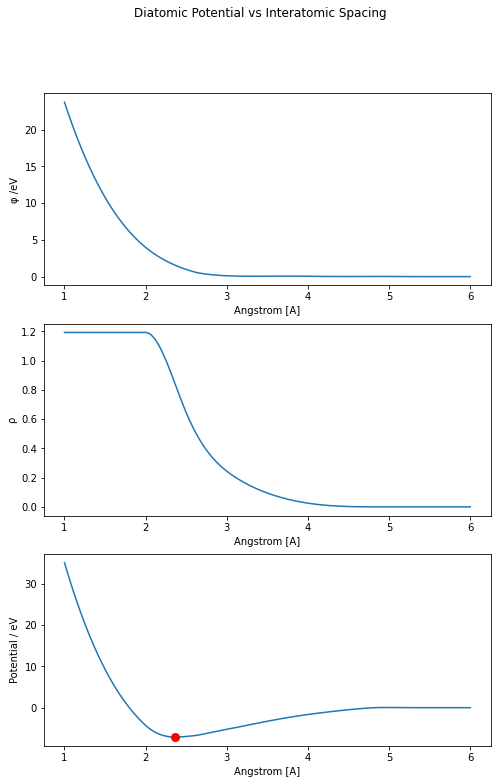

In [825]:
diatomic = Molecular_Dynamics(np.array([[0, 0, 0], [2, 2, 2]]), np.array([10, 10, 10]))
x = np.linspace(1,6,100)[:, np.newaxis]

y1 = diatomic.Phi(x)[:, np.newaxis]
y2 = diatomic.Density(x)[:, np.newaxis]
y3 = 2*(diatomic.F(y2) + y1)

# Create subplots with 3 rows and 1 column
fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
fig2.suptitle('Diatomic Potential vs Interatomic Spacing')

# Plot data on the first subplot and set labels
ax1.plot(x, y1)
ax1.set_ylabel('\u03C6 /eV')  # Y-axis label for the first subplot (phi is the Greek letter)
ax1.set_xlabel('Angstrom [A]')  # X-axis label for all subplots

# Plot data on the second subplot and set labels
ax2.plot(x, y2)
ax2.set_ylabel('\u03C1')  # Y-axis label for the second subplot (rho is the Greek letter)
ax2.set_xlabel('Angstrom [A]')  # X-axis label for all subplots

# Plot data on the third subplot and set labels
ax3.plot(x, y3)
ax3.set_ylabel('Potential / eV')  # Y-axis label for the third subplot
ax3.set_xlabel('Angstrom [A]')  # X-axis label for all subplots

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)  # You can change the value to control vertical spacing

# Find and mark the minimum in the first subplot
min_idx = np.argmin(y3)
ax3.plot(x[min_idx], y3[min_idx], 'ro', markersize=8)
print('Min Energy:' + str(y3[min_idx]) +' eV')
print('At a distance of :' + str(x[min_idx]) + ' A')

### Functions to Plot 3D Scatterplots and Vector Fields

In [826]:

def plt_3D_scatter(pos, f):
    #Plot the Energy
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pos[:,0], pos[:,1], pos[:,2], 
                         c=f, cmap='viridis', marker='o')

    # Add a color bar to the plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('Energy')
    
    plt.show()

def plt_3D_vector(pos, force):
    # Calculate the magnitude of each vector in 'force'.
    magnitude = np.linalg.norm(force, axis=1)

    # Normalize the vectors by dividing each vector by its magnitude.
    normalized_force = force / magnitude[:, np.newaxis]

    # Create a 3D plot.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define the colormap you want to use (e.g., 'viridis', 'plasma', 'magma', 'inferno', etc.).
    colormap = 'viridis'

    # Create a ScalarMappable to map the magnitude values to colors in the chosen colormap.
    sm = ScalarMappable(cmap=colormap)
    sm.set_array(magnitude)

    # Plot the vector field using the 'quiver' function with color based on magnitude.
    q = ax.quiver(pos[:, 0], pos[:, 1], pos[:, 2],
                  normalized_force[:, 0], normalized_force[:, 1], normalized_force[:, 2],
                  color=sm.to_rgba(magnitude), length=1.5, normalize=True)

    # Add a colorbar to show the mapping of values to colors.
    cbar = plt.colorbar(sm, orientation='vertical', ax=ax)  # Specify the 'ax' parameter.
    cbar.set_label('Magnitude')

    # Set axis labels (optional).
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot.
    plt.show()


### Function to form the BCC Crystal

In [827]:
def BCC(a, n_cell):
#BCC Atom Postions

    #Initial Index of a BCC crystal
    r0 = a*np.array([
        [0,0,0],
        [0.5,0.5,0.5]
    ])
    #Initialize
    r = np.zeros([2*n_cell**3, 3])
    
    #Loop through all directions and build the crystal
    for i in range(n_cell):
        for j in range(n_cell):
            for k in range(n_cell):
                offset = np.array([i, j, k])*a
                idx = (i*n_cell**2 + j*n_cell + k)*2 
                r[idx:idx+2,:] = r0 + offset
    return r

#Initialize the atomic distance and the number of cells of interest
a = 3.14339
n_cell = 4

### Form a perfect BCC crystal and apply MD

11.001865


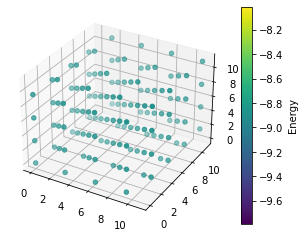

-8.899995814008976


In [828]:
#Build the crystal
bcc_perfect = BCC(a, n_cell)
print(bcc_perfect.max())

boxsize = a*n_cell*np.ones(3)
#Use the Initalize the Class
BCC_Perfect = Molecular_Dynamics(bcc_perfect, boxsize)
BCC_Perfect.Update_Properties(True, True, False)
plt_3D_scatter(bcc_perfect, BCC_Perfect.potential)
print(BCC_Perfect.potential.mean())

### Plotting the Forces on each atom in the crystal

<ipython-input-826-6479a1f4dc54>:19: RuntimeWarning: invalid value encountered in divide
  normalized_force = force / magnitude[:, np.newaxis]


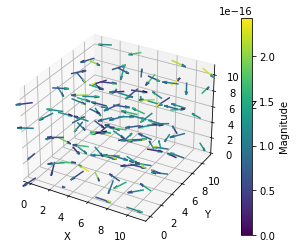

In [829]:
#Find the Force on each atom
plt_3D_vector(bcc_perfect, BCC_Perfect.force)

### Using Finite Differences to check the accuracy of the found force 

In [830]:
delta = 1e-5

force_fd = BCC_Perfect.Force_FD(delta)

residual = force_fd - BCC_Perfect.force

print('Mean of Residual between analytical and finite-difference forces: ' +
      str(np.mean(np.linalg.norm(residual, axis = 1) )) )

Mean of Residual between analytical and finite-difference forces: 5.393393298737362e-05


### Changing the Crystal Structure by removing an atom

In [831]:
#Create a vacany in the perfect crystal by removing an atom
c_idx = n_cell // 2
central_atom = [ (c_idx*n_cell**2 + c_idx*n_cell + c_idx)*2 ]
print(bcc_perfect[central_atom], bcc_perfect.max())
bcc_vacant = np.delete(bcc_perfect, central_atom, axis = 0)

print(bcc_vacant.shape)

[[6.28678 6.28678 6.28678]] 11.001865
(127, 3)


### Plotting the Energy of the Vacant Crystal

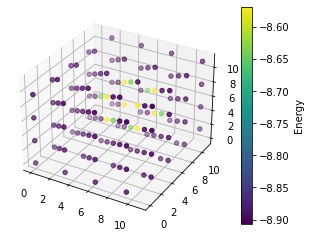

In [832]:
#Use the Initalize the Class
BCC_Vacant = Molecular_Dynamics(bcc_vacant, boxsize)
BCC_Vacant.Update_Properties(True, True, False)

plt_3D_scatter(bcc_vacant, BCC_Vacant.potential)

### Plotting the Forces of the Vacant Crystal

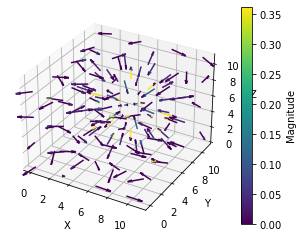

In [833]:
plt_3D_vector(bcc_vacant, BCC_Vacant.force)

### Hessian Testing

In [834]:
hessian = BCC_Vacant.Hessian()
hessian_fd = BCC_Vacant.Hessian_FD(1e-6)

In [835]:
optim_vacancy, error_lst, alpha_lst, potential_lst = BCC_Vacant.Optimize_xyz('vacancy', alpha = 2e-1)

In [836]:
def plt_optimization(optimized, error_lst, alpha_lst, potential_lst, BCC_Perfect, bcc_perfect):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,12))

    # Plot the data
    ax1.plot(np.arange(len(error_lst)), error_lst)

    # Add labels and a title
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Maximum Force')
    ax1.set_title('Convergence Check')

    # Plot the data
    ax2.plot(np.arange(len(alpha_lst)), alpha_lst)

    # Add labels and a title
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Alpha')
    ax2.set_title('Hyperparameter Evolution')

    # Plot the data
    for i, potential in enumerate(potential_lst):
        potential_lst[i] = potential - sum(BCC_Perfect.potential) + (len(bcc_perfect) - len(optimized) )*BCC_Perfect.potential.mean()

    ax3.plot(np.arange(len(potential_lst)), potential_lst)

    # Add labels and a title
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Formation Energy of the Defect (eV)')

    plt.subplots_adjust(hspace=0.6)  # You can change the value to control vertical spacing
    plt.show()

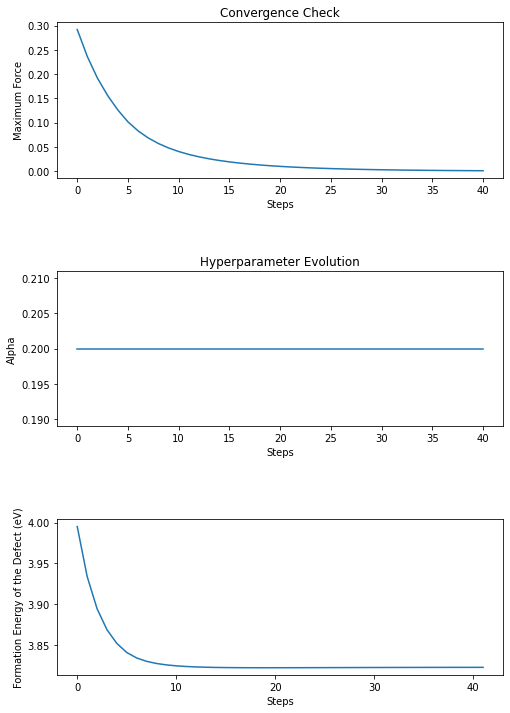

In [837]:
plt_optimization(optim_vacancy, error_lst, alpha_lst, potential_lst, BCC_Perfect, bcc_perfect)

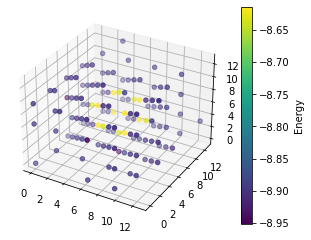

In [838]:
optim_vacancy = np.around(optim_vacancy, decimals = 10)
BCC_Optim_Vacancy = Molecular_Dynamics(optim_vacancy, boxsize)
BCC_Optim_Vacancy.Update_Properties(True, True, False)
plt_3D_scatter(optim_vacancy, BCC_Optim_Vacancy.potential)

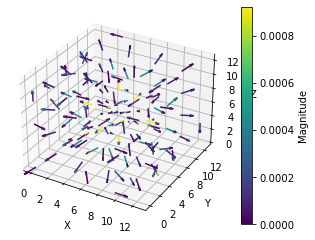

In [839]:
plt_3D_vector(optim_vacancy, BCC_Optim_Vacancy.force)

### Optimizing for the Lattice Constant

Min Energy:-8.884484296180792 eV
At a distance of :3.111111111111111 A


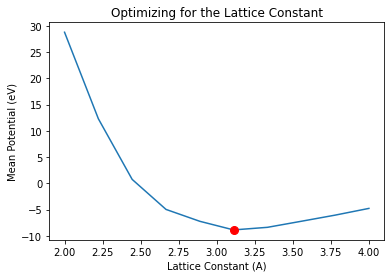

In [840]:
a_plt = np.linspace(2,4,10)
mean_energy = np.zeros(10)

for idx, val in enumerate(a_plt):
    #Build the crystal
    bcc_perf_vary_a = BCC(val, n_cell)
    
    box_vary = val*n_cell
    
    #Use the Initalize the Class
    BCC_perf_vary_a = Molecular_Dynamics(bcc_perf_vary_a, box_vary*np.ones(3) )
    
    BCC_perf_vary_a.Update_Properties(True, False, False)
    
    mean_energy[idx] = BCC_perf_vary_a.potential.mean()
    
fig, ax = plt.subplots()

# Plot the data
ax.plot(a_plt, mean_energy)

# Add labels and a title
ax.set_xlabel('Lattice Constant (A)')
ax.set_ylabel('Mean Potential (eV)')
ax.set_title('Optimizing for the Lattice Constant')

min_idx = np.argmin(mean_energy)
ax.plot(a_plt[min_idx], mean_energy[min_idx], 'ro', markersize=8)
print('Min Energy:' + str(mean_energy[min_idx]) +' eV')
print('At a distance of :' + str(a_plt[min_idx]) + ' A')

### Calculate the Formation Energy of a Vacancy

In [841]:
f_vac = -sum(BCC_Perfect.potential) + sum(BCC_Optim_Vacancy.potential) + BCC_Perfect.potential.mean()
print('Vacancy Formation Energy: ' + str(f_vac) + ' eV')

Vacancy Formation Energy: 3.8223199463508575 eV


### Effects of an Intersitial Atom

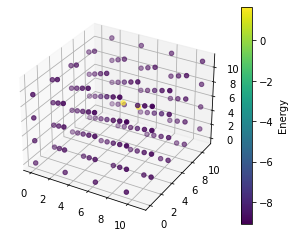

In [842]:
inter_pos = bcc_perfect[central_atom] + 0.25*a*np.array([1,0,0])
bcc_perfect[central_atom] -= 0.25*a*np.array([1,0,0])

bcc_inter = np.vstack([bcc_perfect, inter_pos])

BCC_Inter = Molecular_Dynamics(bcc_inter, boxsize)
BCC_Inter.Update_Properties(True, True, False)

plt_3D_scatter(bcc_inter, BCC_Inter.potential)

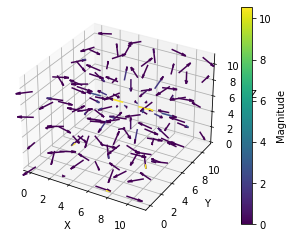

In [843]:
plt_3D_vector(bcc_inter, BCC_Inter.force)

In [844]:
optim_inter, error_lst, alpha_lst, potential_lst = BCC_Inter.Optimize_xyz('intersitial', alpha = 4e-1, reg = 0)

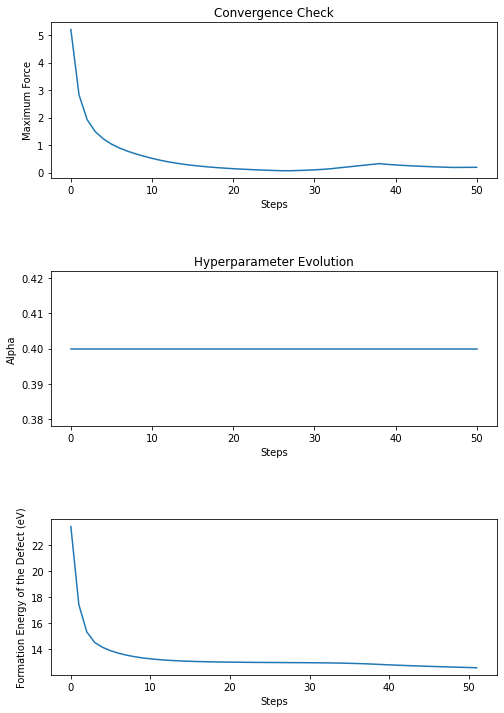

In [845]:
plt_optimization(optim_inter, error_lst, alpha_lst, potential_lst, BCC_Perfect, bcc_perfect)

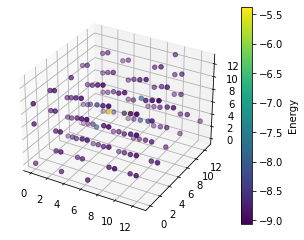

In [846]:
optim_inter = np.around(optim_inter, decimals = 10)
BCC_Optim_Inter = Molecular_Dynamics(optim_inter, boxsize)
BCC_Optim_Inter.Update_Properties(True, True, False)
plt_3D_scatter(optim_inter, BCC_Optim_Inter.potential)

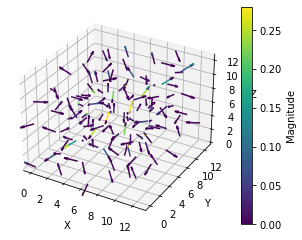

In [847]:
plt_3D_vector(optim_inter, BCC_Optim_Inter.force)

In [848]:
f_inter = -sum(BCC_Perfect.potential) + sum(BCC_Optim_Inter.potential) - BCC_Perfect.potential.mean()
print('Intersitial Formation Energy: ' + str(f_inter) + ' eV')

Intersitial Formation Energy: 12.556954355226567 eV


In [922]:
n_cells = 4

bcc_radiation = BCC(a, n_cells)

c_idx = n_cells // 2
central_atom = [ (c_idx*n_cells**2 + c_idx*n_cells + c_idx)*2 ]

BCC_Radiation = Molecular_Dynamics(bcc_radiation, n_cells*a*np.ones(3))
BCC_Radiation.init_velocity(T = 300)
BCC_Radiation.Update_Properties(True, True, False)

theta = np.pi*np.random.random()
phi   = 2*np.pi*np.random.random()

rnd_unit_vec = np.array([

    np.sin(theta)*np.cos(phi),
    np.sin(theta)*np.sin(phi),
    np.cos(theta)
    
    ])

rnd_unit_vec = np.sqrt(3)*np.ones(3)

amu = 931.49432e6*2.99792458e6**-2

mr = 183.84
m_inv = 1/(amu*mr)

energies = np.linspace(40,60,3)

defect = []

for impulse_energy in energies:

    BCC_Radiation.xyz = bcc_radiation
    BCC_Radiation.Apply_PBC_xyz()
    BCC_Radiation.init_velocity(T = 300)
    BCC_Radiation.Update_Properties(True, True, False)

    impulse_vel    = np.sqrt(2*impulse_energy*m_inv)

    BCC_Radiation.vel[central_atom] += rnd_unit_vec*impulse_vel

    BCC_Radiation.Time_Integration(dt = 1e-4, n_step=1000)

    defect.append(max(BCC_Radiation.ws_analysis))

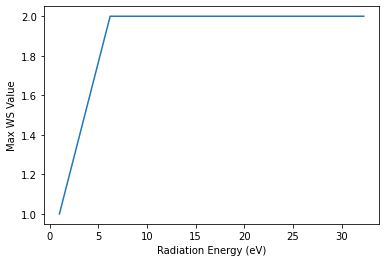

In [921]:
plt.ylabel('Max WS Value')
plt.xlabel('Radiation Energy (eV)')
plt.plot(energies[:len(defect)], defect)

In [917]:
print(defect)

[1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


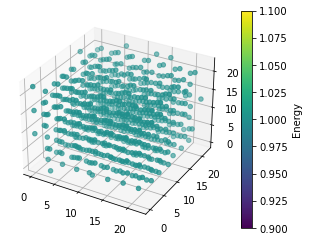

In [890]:
plt_3D_scatter(BCC_Radiation.xyz, BCC_Radiation.ws_analysis)